<a href="https://colab.research.google.com/github/Siarhei-Y/tea_recognition/blob/main/Tea_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import PIL
import PIL.Image
import pathlib

from tensorflow.keras import layers

### Upload data

In [2]:
path = r'/content/drive/MyDrive/Data/tea_recognition/img'
labels = pd.read_csv(r'/content/drive/MyDrive/Data/tea_recognition/train.csv')

In [3]:
# labels.head()

In [4]:
data_dir = pathlib.Path(r'/content/drive/MyDrive/Data/tea_recognition/img/') 
data_dir

PosixPath('/content/drive/MyDrive/Data/tea_recognition/img')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3208


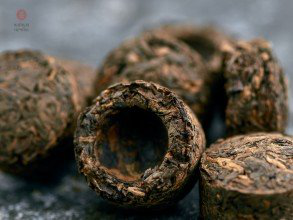

In [9]:
shu = list(data_dir.glob('shu_puerh/*'))
PIL.Image.open(str(shu[0]))

### Create a dataset

In [10]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [27]:
x_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    shuffle= True,
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size= BATCH_SIZE)

Found 3208 files belonging to 8 classes.
Using 2567 files for training.


In [26]:
x_val = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

Found 3208 files belonging to 8 classes.
Using 641 files for validation.


In [28]:
classes = x_train.class_names
print(classes)

['black_tea', 'green_tea', 'phoenix-oolong', 'sheng_puerh', 'shu_puerh', 'south_fujian', 'taiwanese_oolong', 'wyui_oolong']


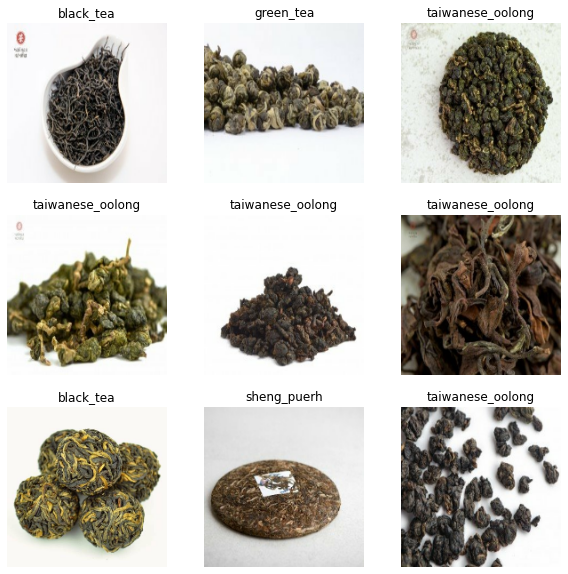

In [29]:
plt.figure(figsize=(10, 10))
for images, labels in x_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(classes[labels[i]])
    plt.axis('off')

In [30]:
for img_batch , labels_batch in x_train:
  print(img_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

x_train = x_train.cache().prefetch(buffer_size=AUTOTUNE)
x_val = x_val.cache().prefetch(buffer_size=AUTOTUNE)

### Train a Baseline


In [32]:
K = len(classes)
EPOCHS = 15 

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(K, activation='softmax')
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [34]:
r = model.fit(
  x_train,
  validation_data=x_val,
  epochs=EPOCHS
)

Epoch 1/15
81/81 [==============================] - 9s 104ms/step - loss: 1.8846 - accuracy: 0.2863 - val_loss: 1.7803 - val_accuracy: 0.3276
Epoch 2/15
81/81 [==============================] - 4s 44ms/step - loss: 1.6512 - accuracy: 0.3833 - val_loss: 1.6423 - val_accuracy: 0.3807
Epoch 3/15
81/81 [==============================] - 4s 44ms/step - loss: 1.3595 - accuracy: 0.4807 - val_loss: 1.4489 - val_accuracy: 0.4524
Epoch 4/15
81/81 [==============================] - 4s 44ms/step - loss: 1.1966 - accuracy: 0.5508 - val_loss: 1.4060 - val_accuracy: 0.4743
Epoch 5/15
81/81 [==============================] - 4s 44ms/step - loss: 1.0359 - accuracy: 0.6213 - val_loss: 1.5703 - val_accuracy: 0.4368
Epoch 6/15
81/81 [==============================] - 4s 44ms/step - loss: 0.9103 - accuracy: 0.6735 - val_loss: 1.4397 - val_accuracy: 0.4930
Epoch 7/15
81/81 [==============================] - 4s 44ms/step - loss: 0.6756 - accuracy: 0.7655 - val_loss: 1.6351 - val_accuracy: 0.4212
Epoch 8/15
8

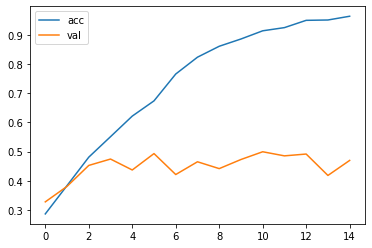

In [35]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val')
plt.legend()

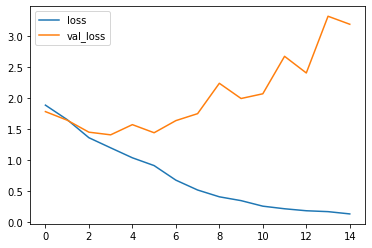

In [36]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

### Tuning
* Data augmentation
* Dropout
* L2 L1 Reg


In [57]:
EPOCHS = 100 
LR = 0.0001

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [58]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(K, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Epoch 1/100
81/81 [==============================] - 5s 52ms/step - loss: 1.9299 - accuracy: 0.2583 - val_loss: 1.9493 - val_accuracy: 0.2543
Epoch 2/100
81/81 [==============================] - 4s 49ms/step - loss: 1.8156 - accuracy: 0.2988 - val_loss: 1.7644 - val_accuracy: 0.3042
Epoch 3/100
81/81 [==============================] - 4s 49ms/step - loss: 1.6532 - accuracy: 0.3697 - val_loss: 1.6513 - val_accuracy: 0.3385
Epoch 4/100
81/81 [==============================] - 4s 49ms/step - loss: 1.5566 - accuracy: 0.3923 - val_loss: 1.6075 - val_accuracy: 0.3479
Epoch 5/100
81/81 [==============================] - 4s 49ms/step - loss: 1.5112 - accuracy: 0.4090 - val_loss: 1.5876 - val_accuracy: 0.3666
Epoch 6/100
81/81 [==============================] - 4s 49ms/step - loss: 1.4784 - accuracy: 0.4207 - val_loss: 1.5714 - val_accuracy: 0.3760
Epoch 7/100
81/81 [==============================] - 4s 49ms/step - loss: 1.4517 - accuracy: 0.4375 - val_loss: 1.5499 - val_accuracy: 0.3838
Epoch 

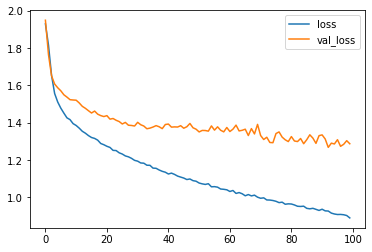

In [59]:
r = model.fit(
  x_train,
  validation_data=x_val,
  epochs=EPOCHS,
  callbacks=[callback]
)

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()